<a href="https://colab.research.google.com/github/RumeysaCeylan/ImageClassification/blob/main/densenet169_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
#IMPORT / VIEWING / PREPROCESSING DATASET

In [4]:
#DATA AUGMENTATION

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 19175 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Validation',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 799 images belonging to 4 classes.


100%|██████████| 5/5 [03:35<00:00, 43.03s/it]


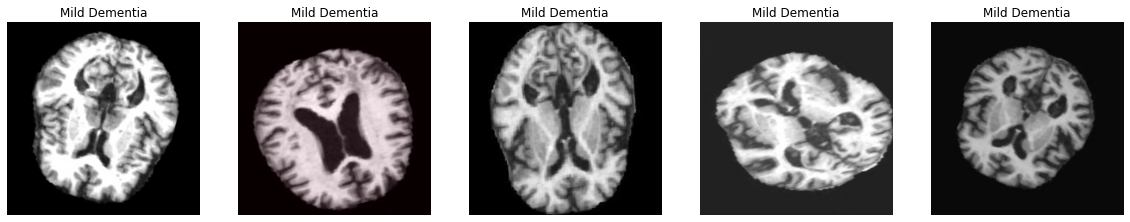

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [9]:
#MODEL BUILDING

In [10]:
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 0s 0us/step


In [11]:

# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [12]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [13]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [14]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [15]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [16]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 1.1458 - auc: 0.8045 
Epoch 1: val_auc improved from -inf to 0.92864, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
150/150 [==============================] - 3937s 26s/step - loss: 1.1458 - auc: 0.8045 - val_loss: 0.6306 - val_auc: 0.9286
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.8182 - auc: 0.8813
Epoch 2: val_auc improved from 0.92864 to 0.94890, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
150/150 [==============================] - 274s 2s/step - loss: 0.8182 - auc: 0.8813 - val_loss: 0.5349 - val_auc: 0.9489
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.7298 - auc: 0.9035
Epoch 3: val_auc improved from 0.94890 to 0.94947, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
150/150 [==============================] - 269s 2s/step - loss: 0.7298 - auc: 0.9035 - val_loss: 0.5221 - val_a

In [17]:
#MODEL EVALUATION

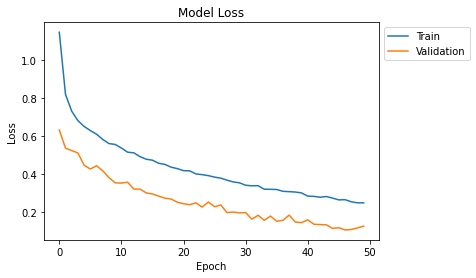

In [18]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

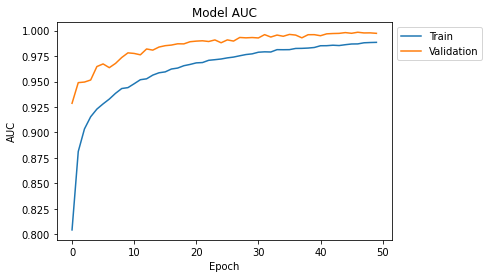

In [19]:
# Summarize history for auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [20]:
import tensorflow as tf
final_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5')


In [21]:
pred = final_model.predict(train_dataset, batch_size = 8)

150/150 [==============================] - 260s 2s/step


In [22]:
pred_final = np.where(pred>0.5,1,0)

In [23]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 2000 images belonging to 4 classes.


In [24]:
def perf_measure(y_test, pred_final):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred_final)): 
        if y_test[i]==pred_final[i]==1:
           TP += 1
        if y_test[i]==1 and y_test[i]!=pred_final[i]:
           FP += 1
        if y_test[i]==pred_final[i]==0:
           TN += 1
        if y_test[i]==0 and y_test[i]!=pred_final[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [25]:
tp, fp, tn ,fn = perf_measure(test_dataset,pred_final)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

<ipython-input-24-3f33b41492dd>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if y_test[i]==pred_final[i]==1:
<ipython-input-24-3f33b41492dd>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if y_test[i]==pred_final[i]==1:
<ipython-input-24-3f33b41492dd>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if y_test[i]==pred_final[i]==0:
<ipython-input-24-3f33b41492dd>:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if y_test[i]==pred_final[i]==0:


ValueError: ignored

In [61]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
from sklearn.metrics import classification_report, confusion_matrix
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred:
    labels = roundoff(labels)

print(classification_report(test_dataset, pred, target_names=CLASSES))

ValueError: ignored

In [ ]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred, axis=1)
test_ls = np.argmax(test_dataset, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [26]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)


16/16 [==============================] - 11s 663ms/step - loss: 0.1523 - auc: 0.9956


[0.1522984802722931, 0.99562668800354]

In [27]:
# Evaluating Loss and AUC

_,acc=model.evaluate(test_dataset)
print("Accuracy = ", (100*acc), "%")

16/16 [==============================] - 7s 420ms/step - loss: 0.1523 - auc: 0.9956
Accuracy =  99.562668800354 %


In [28]:
from sklearn.metrics import plot_roc_curve
y_preds=model.predict(test_dataset).ravel()

fpr,tpr,thresholds = plot_roc_curve(test_dataset, y_preds)
plt.figure(1)
plt.plot([0,1],[0,1],'y--')
plt.plot(fpr,tpr,marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

16/16 [==============================] - 9s 429ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


TypeError: ignored

In [29]:
# Get the confusion matrix

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(test_dataset, pred_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['non-dementia','moderate-dementia','mild-dementia','very-mild-dementia'], fontsize=10)
plt.yticks(range(2), ['non-dementia','moderate-dementia','mild-dementia','very-mild-dementia'], fontsize=10)
plt.show()

ValueError: ignored

1/1 [==============================] - 4s 4s/step
99.79 % chances are there that the image is NonDemented


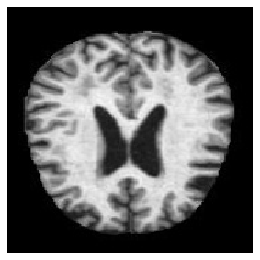

In [30]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/00b8529f-23c6-415c-96cc-a4e6ca6ed6ac.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 44ms/step
99.97 % chances are there that the image is NonDemented


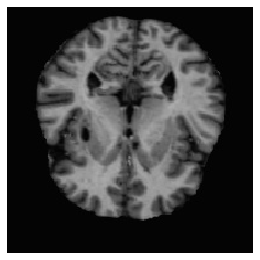

In [31]:
# Test Case 1_1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/00e94d2d-4d78-43eb-933e-1c8cbfe974fd.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 48ms/step
100.0 % chances are there that the image is NonDemented


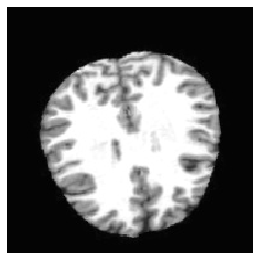

In [32]:
# Test Case 1_2: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/01a1f60e-a95b-4f6b-b84a-d35c5b241bb1.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 43ms/step
99.16 % chances are there that the image is NonDemented


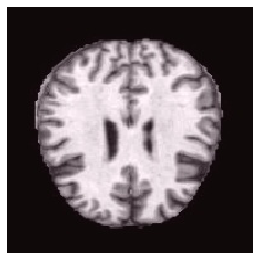

In [33]:
# Test Case 1_3: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/0ab1d152-a70b-451a-9840-da1bb72e6b91.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 44ms/step
98.96 % chances are there that the image is NonDemented


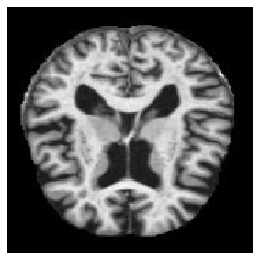

In [34]:
# Test Case 1_4: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/0b7e0c7c-eee7-49de-931c-cffaa8d1bbcc.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 45ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 39ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 34ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 32ms/step
99.99 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 96ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 32ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 36ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 34ms/step
100.0 % chances are there that the image is 

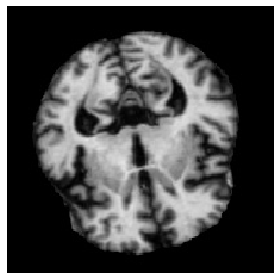

In [35]:


import cv2
import glob 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/ModerateDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [36]:
# MODERATE 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/ModerateDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "ModerateDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 40ms/step
correct: 500
images: 500
percentage: 1.0


1/1 [==============================] - 0s 84ms/step
79.5 % chances are there that the image is VeryMildDemented
1/1 [==============================] - 0s 121ms/step
99.63 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 132ms/step
73.92 % chances are there that the image is NonDemented
1/1 [==============================] - 0s 134ms/step
99.99 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 162ms/step
49.21 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 143ms/step
98.18 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 140ms/step
99.53 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 79ms/step
99.99 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 59ms/step
99.81 % chances are there that the image is MildDemented
1/1 [======

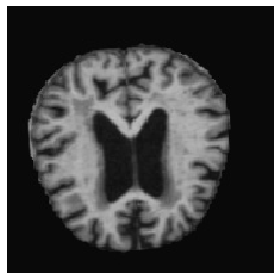

In [39]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [40]:
# MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 33ms/step
correct: 480
images: 500
percentage: 0.96


In [41]:
# NON

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/NonDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "NonDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 31ms/step
correct: 472
images: 500
percentage: 0.944


In [44]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 32ms/step
correct: 480
images: 500
percentage: 0.96


In [43]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/VeryMildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "VeryMildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 33ms/step
correct: 425
images: 500
percentage: 0.85
